# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [17]:
!pip install -r requirements.txt    

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [18]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [19]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [20]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [21]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [22]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset()
    observation = observation[0]
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      # what goes here? TODO
      action = torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)
  
  return fitness, memory

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [36]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] #Add your own operators here

evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=64,
  max_gens=10,
  max_tree_size=55,
  n_jobs=8,
  verbose=True)

In [43]:
import random
import numpy as np
import torch
import pandas as pd

# Initialize lists to store results
tree_sizes = []
bests = []
nodes = []
average_test_scores = []
num_constants_list = []
pop_size_list = []

# Define the test score function
def get_test_score(tree):
    rewards = []

    for i in range(10):
        # get initial state
        observation = env.reset(seed=i)
        observation = observation[0]

        for _ in range(500):
            # build up the input sample for GP
            input_sample = torch.from_numpy(observation.reshape((1, -1))).float()
            # get output (squeezing because it is encapsulated in an array)
            output = tree.get_output_pt(input_sample)
            action = torch.argmax(output)
            observation, reward, terminated, truncated, info = env.step(action.item())
            rewards.append(reward)

            output_sample = torch.from_numpy(observation.reshape((1, -1))).float()
            if terminated or truncated:
                break

    fitness = np.sum(rewards)
    return fitness

# Define hyperparameter ranges
num_constants_range = [0, 1, 3, 5]
pop_size_range = [16, 32, 64, 128]

# Random search for hyperparameters
for _ in range(50):
    num_features = env.observation_space.shape[0]
    internal_nodes = [Plus(), Minus(), Times(), Div()]  # Add your own operators here
    extra_internal = [Square(), Sqrt(), Log(), Sin(), Cos(), Max(), Min()]
    internal_nodes += random.sample(extra_internal, random.randint(0, len(extra_internal)))

    # Randomly select hyperparameters
    num_constants = random.choice(num_constants_range)
    pop_size = random.choice(pop_size_range)
    max_tree_size = random.randint(30, 100)
    
    # Define the terminal set
    leaf_nodes = [Feature(i) for i in range(num_features)] + [Constant()] * num_constants

    nodes.append(internal_nodes)
    tree_sizes.append(max_tree_size)
    num_constants_list.append(num_constants)
    pop_size_list.append(pop_size)

    test_scores = []
    for _ in range(5):  # Run each setting 5 times
        evo = Evolution(
            fitness_function_pt, internal_nodes, leaf_nodes,
            4,
            pop_size=pop_size,
            max_gens=10,
            max_tree_size=max_tree_size,
            n_jobs=8,
            verbose=True
        )

        evo.evolve()

        best = evo.best_of_gens[-1]
        test_score = get_test_score(best)
        test_scores.append(test_score)
        bests.append(best.get_readable_repr())
        print("Test score:", test_score)

    average_test = np.mean(test_scores)
    average_test_scores.append(average_test)

    print(best.get_readable_repr())
    print("Average Best Score:", average_test)

# Save the results to a CSV file
df_results = pd.DataFrame({
    'Tree Size': tree_sizes,
    'Num Constants': num_constants_list,
    'Population Size': pop_size_list,
    'Nodes Used': [str(node_set) for node_set in nodes],
    'Average Test Scores': average_test_scores
})
df_results.to_csv('gp_results.csv', index=False)

# Print results
print("Tree Sizes:", tree_sizes)
print("Best Individuals:", bests)
print("Nodes Used:", nodes)
print("Average Test Scores:", average_test_scores)


KeyboardInterrupt: 

    ## Evolve
Running this cell will use all the settings above as parameters

In [37]:
evo.evolve()

gen: 1,	best of gen fitness: -462.648,	best of gen size: 37
gen: 2,	best of gen fitness: -119.237,	best of gen size: 25
gen: 3,	best of gen fitness: -370.402,	best of gen size: 29
gen: 4,	best of gen fitness: -333.784,	best of gen size: 41
gen: 5,	best of gen fitness: -150.791,	best of gen size: 41
gen: 6,	best of gen fitness: -223.206,	best of gen size: 37
gen: 7,	best of gen fitness: -319.773,	best of gen size: 25
gen: 8,	best of gen fitness: -174.958,	best of gen size: 37
gen: 9,	best of gen fitness: -179.215,	best of gen size: 41
gen: 10,	best of gen fitness: -36.306,	best of gen size: 37


# Test

In [38]:
def get_test_score(tree):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output)
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness

best = evo.best_of_gens[-1]

print(best.get_readable_repr())
print(get_test_score(best))

['(((x_2*(x_4/x_0))*(((x_3*x_3)+(x_5+x_2))+(x_5*(x_1-x_0))))-(((x_3/x_6)+x_4)/((x_7+-4.165583610534668)*(x_0+x_3))))', '(((x_6-x_5)*((((x_1/x_5)+(x_6/x_4))/((x_0+x_0)+x_0))-((x_3*(x_4/x_2))*((x_3-x_0)/(x_6-x_0)))))/((x_0*-0.6209388971328735)*x_0))', '(((x_6-(x_2+((((x_6/x_5)/(x_7/-4.220213890075684))/(x_5+x_0))*(((x_4+x_0)/x_3)/(x_5-x_5)))))*((x_4+x_4)/x_1))+((x_3*x_0)/x_7))', '((((x_0-x_3)*(x_5-x_2))-x_3)*(((x_3*x_0)+(x_3+x_7))+((x_4/x_7)/x_1)))']
-1114.5184453007448


## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

MovieWriter imagemagick unavailable; using Pillow instead.


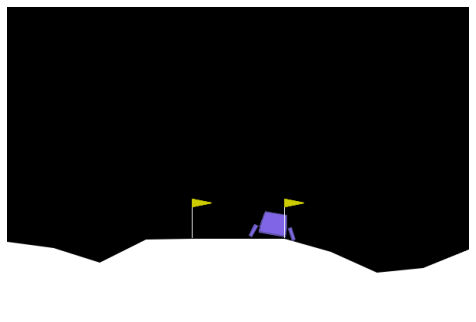

In [39]:
frames = []
 
# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [40]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

['(((x_2*(x_4/x_0))*(((x_3*x_3)+(x_5+x_2))+(x_5*(x_1-x_0))))-(((x_3/x_6)+x_4)/((x_7+-4.395212650299072)*(x_0+x_3))))', '(((x_6-x_5)*((((x_1/x_5)+(x_6/x_4))/((x_0+x_0)+x_0))-((x_3*(x_4/x_2))*((x_3-x_0)/(x_6-x_0)))))/((x_0*-0.7047637104988098)*x_0))', '(((x_6-(x_2+((((x_6/x_5)/(x_7/-4.102983474731445))/(x_5+x_0))*(((x_4+x_0)/x_3)/(x_5-x_5)))))*((x_4+x_4)/x_1))+((x_3*x_0)/x_7))', '((((x_0-x_3)*(x_5-x_2))-x_3)*(((x_3*x_0)+(x_3+x_7))+((x_4/x_7)/x_1)))']
-1207.0874682199064


MovieWriter imagemagick unavailable; using Pillow instead.


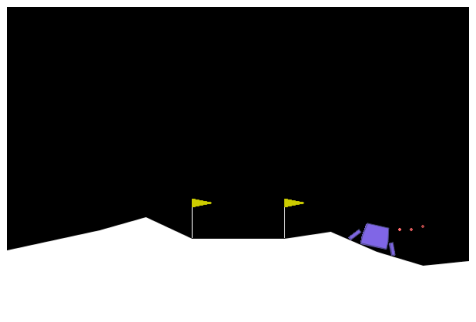

In [29]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">